In [ ]:
#Importing all the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from torchvision import models,datasets,transforms

from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
import pickle

In [ ]:
#Checking if a GPU with CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#Creating a custom dataset class that generates the noisy counterpart of the clean image and returns both of them
class CustomDataset(Dataset):
  def __init__(self,dir_name,train_flag,sigma):
    """
    train_flag is True for the Train dataset and False for the evaluation dataset
    sigma is the noise level
    """
    super().__init__()
    #Defining the transforms for the train and test datasets
    self.test_transform = transforms.Compose([transforms.ToTensor()])

    self.train_flag = train_flag

    #Downloading the train and test datasets
    if train_flag:
      pfile = open(dir_name, 'rb')     #opening the pickle file
      self.dataset = pickle.load(pfile) #Reading the tensors from the pickle file
      pfile.close() #Closing the pickle file

    else:
      self.dataset = []
      for img_name in os.listdir(dir_name):
        self.dataset.append(os.path.join(dir_name,img_name))

    self.sigma = sigma

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if self.train_flag:
      clean_img = self.dataset[index].unsqueeze(0) #of shape (1,40,40)

    else:
      im = Image.open(self.dataset[index])
      clean_img = self.test_transform(im) #of shape (1,h,w)

    #Generating the noisy image
    noisy_img = (torch.randn(clean_img.shape)*(self.sigma/255.))+clean_img
    return clean_img, noisy_img



In [ ]:
#Defining a Block of the DnCNN
class Block(nn.Module):
  def __init__(self,k=3,p=1,c=64):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=c,out_channels=c,kernel_size=k,padding=p,bias=False) #same padding convolution
    self.norm = nn.BatchNorm2d(c) #batch normalization
    self.relu = nn.ReLU(inplace=True) #activation function

  def forward(self,x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.relu(x)
    return x

In [ ]:
#Defining the DnCNN model
class DCNN(nn.Module):
  def __init__(self,k=3,p=1,c=64,l=17,in_c=1):
    super().__init__()
    layers = [nn.Conv2d(in_channels=in_c,out_channels=c,kernel_size=k,padding=p,bias=False), #First same padding convolution layer
              nn.ReLU(inplace=True)]
    layers.extend([Block(k,p,c) for _ in range(l-2)]) #Adding all the "Blocks" to the model
    layers.append(nn.Conv2d(in_channels=c,out_channels=in_c,kernel_size=k,padding=p,bias=False)) #Last same padding convolution layer

    self.all = nn.Sequential(*layers)

  def forward(self,x):
    out = self.all(x)
    return x-out


In [ ]:
#Function for unsupervised training of the model
def train(criterion,optimizer,model,device,train_loader,sigma,alpha):
  """
  criterion is the loss function
  optimizer is the optimization algorithm used
  model is the denoiser model
  device is either CPU or GPU(cuda)
  train_loader is the DataLoader containing the training dataset
  sigma is the noise level
  alpha is the constant of 0.5
  """
  model.train()
  loop = tqdm(train_loader) #Used to visualized the progress in training
  cur_loss = 0.0

  for i,(_,noisy) in enumerate(loop): #iterating batch-by-batch through the dataset
    noisy = noisy.to(device) #Moving over the data to the "device"

    #Generating pair of noisy images from the noisy image
    noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
    noisy1 = noisy+alpha*noise
    noisy2 = noisy-noise/alpha

    noisy2_pred = model(noisy1) #Passing the data through the model
    loss = criterion(noisy2_pred,noisy2) #Computing the loss

    optimizer.zero_grad() #Zeroing all the previous gradients
    loss.backward() #Computing the gradients for the current iteration
    optimizer.step() #Updating the weights of the model

    cur_loss += loss.item() #Keeping track of the loss
    loop.set_postfix(loss=cur_loss/(i+1)) #Printing the cumulative loss after each iteration

In [ ]:
#Function for testing the model
def test(criterion,model,device,test_loader,alpha,sigma,T):
  """
  criterion is the function used to compute PSNR
  model is the denoiser model
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  sigma is the noise level
  alpha is the constant of 0.5
  T is the number of forward processes averaged to reduce the effect of recorruption
  """

  model.eval()
  loop = tqdm(test_loader) #Used to visualized the progress in testing
  total_mse = []

  with torch.no_grad(): #Ensures that the gradients are not computed
    for i,(clean,noisy) in enumerate(loop): #iterating batch-by-batch through the dataset
      clean,noisy = clean.to(device).float(), noisy.to(device).float() #Moving over the data to the "device"

      #Averaging T forward passes
      out = torch.zeros(clean.shape).to(device)
      for _ in range(T):
        noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
        noisy_main = noisy+alpha*noise
        out += model(noisy_main) #Passing the data through the model

      clean_pred = torch.clamp(out/T,min=0.0,max=1.0) #Clips all the values greater than 1 or less than 0
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist() #Computing MSE at an image level
      total_mse.extend(loss)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean() #Computing the PSNR using the corresponding MSE values

  print(f"The PSNR is {psnr}")
  return psnr.item()

In [ ]:
#Function to computer the number of parameters in a model
def number_of_parameters(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

In [ ]:
#Wrapper function to train and evaluate the denoiser model
def wrapper(sigma):
  print(f"This is for sigma of {sigma}")

  #Defines the loaders for the train and test set
  train_set = CustomDataset("/content/drive/MyDrive/R2R_ML/BSD400_train.pkl",True,sigma)
  test_set = CustomDataset("/content/drive/MyDrive/R2R_ML/test",False,sigma)

  train_loader = DataLoader(train_set,batch_size=128,shuffle=True,num_workers=128)
  test_loader = DataLoader(test_set,batch_size=1,shuffle=False,num_workers=1)

  print(f"The number of images in the train set is {len(train_set)}")
  print(f"The number of images in the test set is {(len(test_set))}")

  #Defining the model, loss function and optimizer
  model = DCNN().to(device)
  criterion_train = nn.MSELoss()
  criterion_test = nn.MSELoss(reduce=False)
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  epochs = 20
  alpha = 0.5
  T = 50

  print(f"The model has {number_of_parameters(model)} parameters")
  #Computing the PSNR between the noisy and clean image
  total_mse = []
  with torch.no_grad():
      for i,(clean,noisy) in enumerate(test_loader):
        clean,noisy = clean.to(device), noisy.to(device)
        loss = (criterion_test(noisy,clean).mean(axis=(1,2,3))).tolist()
        total_mse.extend(loss)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()
  print(f"The PSNR for an untrained densoiser is {psnr}")

  #Iterating through the epochs
  for epoch in range(epochs):
    print(f"The current epoch is {epoch}")
    train(criterion_train,optimizer,model,device,train_loader,sigma,alpha)
    cur_psnr = test(criterion_test,model,device,test_loader,alpha,sigma,T)
    torch.save(model.state_dict(), "Unsupervised"+str(epoch)+"_"+str(round(cur_psnr,2))+"_"+ str(sigma) + ".pt")


In [ ]:
#For sigma value of 10
wrapper(10)

This is for sigma of 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The number of images in the train set is 238400
The number of images in the test set is 68
The model has 556032 parameters


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


The PSNR for an untrained densoiser is 28.131715774536133
The current epoch is 0


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 32.4364013671875
The current epoch is 1


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 32.89314651489258
The current epoch is 2


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.11648178100586
The current epoch is 3


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.304931640625
The current epoch is 4


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.360233306884766
The current epoch is 5


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.47332763671875
The current epoch is 6


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.51907730102539
The current epoch is 7


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 31.883867263793945
The current epoch is 8


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.20092010498047
The current epoch is 9


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.42930603027344
The current epoch is 10


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.28449630737305
The current epoch is 11


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 32.969337463378906
The current epoch is 12


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.42909622192383
The current epoch is 13


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 32.6094970703125
The current epoch is 14


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.52730941772461
The current epoch is 15


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 33.300018310546875
The current epoch is 16


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.488861083984375
The current epoch is 17


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.20964050292969
The current epoch is 18


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 33.16132354736328
The current epoch is 19


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

The PSNR is 33.19843292236328


In [ ]:
#For sigma value of 25
wrapper(25)

This is for sigma of 25
The number of images in the train set is 238400
The number of images in the test set is 68
The model has 556032 parameters
The PSNR for an untrained densoiser is 20.172466278076172
The current epoch is 0


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 28.133682250976562
The current epoch is 1


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.227664947509766
The current epoch is 2


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 28.281938552856445
The current epoch is 3


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.57613182067871
The current epoch is 4


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.49190330505371
The current epoch is 5


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.609848022460938
The current epoch is 6


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.72161865234375
The current epoch is 7


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.822063446044922
The current epoch is 8


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.82069969177246
The current epoch is 9


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.814353942871094
The current epoch is 10


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.81367301940918
The current epoch is 11


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.872034072875977
The current epoch is 12


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.873733520507812
The current epoch is 13


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.859634399414062
The current epoch is 14


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.96596908569336
The current epoch is 15


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.815370559692383
The current epoch is 16


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.952377319335938
The current epoch is 17


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 28.95878028869629
The current epoch is 18


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 29.011600494384766
The current epoch is 19


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]

The PSNR is 28.976713180541992


In [ ]:
#For sigma value of 50
wrapper(50)

This is for sigma of 50
The number of images in the train set is 238400
The number of images in the test set is 68
The model has 556032 parameters
The PSNR for an untrained densoiser is 14.15442180633545
The current epoch is 0


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 24.720657348632812
The current epoch is 1


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 25.069169998168945
The current epoch is 2


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 25.30653190612793
The current epoch is 3


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 24.836225509643555
The current epoch is 4


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 25.437225341796875
The current epoch is 5


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 24.943199157714844
The current epoch is 6


100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


The PSNR is 25.492576599121094
The current epoch is 7


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.39081573486328
The current epoch is 8


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.615190505981445
The current epoch is 9


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.71251678466797
The current epoch is 10


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.777935028076172
The current epoch is 11


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.692062377929688
The current epoch is 12


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.663347244262695
The current epoch is 13


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.672819137573242
The current epoch is 14


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.89620018005371
The current epoch is 15


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.814533233642578
The current epoch is 16


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.87978172302246
The current epoch is 17


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.869155883789062
The current epoch is 18


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]


The PSNR is 25.902721405029297
The current epoch is 19


100%|██████████| 68/68 [00:51<00:00,  1.31it/s]

The PSNR is 25.927993774414062


Text(0.5, 1.0, 'Unsupervised Denoised Image')

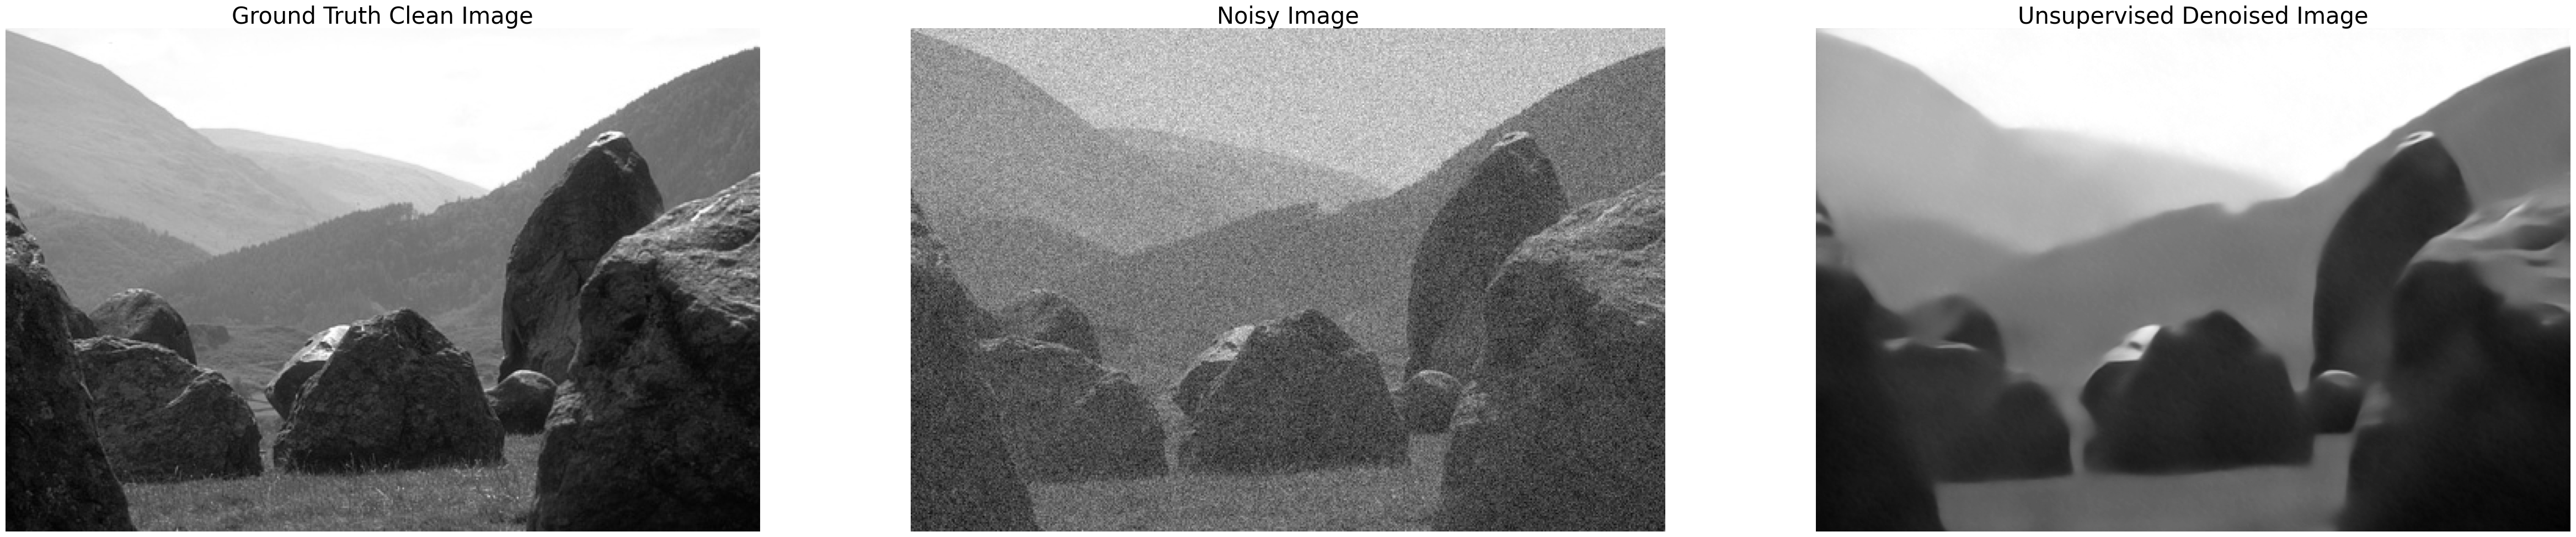

In [ ]:
model = DCNN().to(device)
model.load_state_dict(torch.load("/content/Unsupervised19_25.93_50.pt"))
test_set = CustomDataset("/content/drive/MyDrive/R2R_ML/test",False,25)

index = 0
clean, noisy = test_set[index]
model.eval()
noisy = noisy.to(device)
out_unsup = torch.zeros(noisy.shape).unsqueeze(0).to(device)

with torch.no_grad():
  for _ in range(50):
    noise = (torch.randn(noisy.shape)*(25/255.)).to(device)
    noisy_main = noisy+0.5*noise
    out_unsup += model(noisy_main.unsqueeze(0))

clean_pred_unsup = torch.clamp(out_unsup/50,min=0.0,max=1.0)
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(60,30))

axes[0].imshow(clean.cpu().squeeze(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Ground Truth Clean Image",fontsize=30)

axes[1].imshow(noisy.cpu().squeeze(),cmap="gray")
axes[1].axis("off")
axes[1].set_title("Noisy Image",fontsize=30)

axes[2].imshow(clean_pred_unsup.cpu().squeeze().detach(),cmap="gray")
axes[2].axis("off")
axes[2].set_title("Unsupervised Denoised Image",fontsize=30)